<a href="https://colab.research.google.com/github/vaas-umputer/naan_mudhalvan_genAI_3562/blob/main/nm_genAI_2021503562.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys

import tensorflow
from tensorflow.keras.layers import Dense, Input, BatchNormalization,Dropout,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
#Data Loading
mnist=tensorflow.keras.datasets.mnist
(X_train,y_train),(X_test,y_test)=mnist.load_data()

#scaling to between -1 and 1
X_train=X_train/255.0
X_test=X_test/255.0
X_train=X_train*2-1
X_test=X_test*2-1
#Flatten the data
X_train=X_train.reshape(-1,X_train.shape[1]*X_train.shape[2])
X_test=X_test.reshape(-1,X_test.shape[1]*X_test.shape[2])

In [ ]:
D=X_train.shape[1]
print(X_train.shape)
print(X_test.shape)
print(D)

(60000, 784)
(10000, 784)
784


In [ ]:
#Create Generator Architecture
l_dim=100 #latemt dimensionality

def build_gen(l_dim):
    a=Input(shape=(l_dim,))
    b=Dense(512,activation=LeakyReLU(alpha=0.2))(a)
    b=BatchNormalization(momentum=0.7)(b)
    b=Dense(1024,activation=LeakyReLU(alpha=0.2))(b)
    b=BatchNormalization(momentum=0.7)(b)
    b=Dense(1024,activation=LeakyReLU(alpha=0.2))(b)
    b=BatchNormalization(momentum=0.7)(b)
    b=Dense(D,activation='tanh')(b) #activation is tanh because images are scaled between -1 and 1

    model=Model(a,b)
    return model

In [ ]:
#Create Discriminator Architecture

def build_dis(image_size):
    a=Input(shape=(image_size,))
    b=Dense(512,activation=LeakyReLU(alpha=0.2))(a)
    b=Dense(1024,activation=LeakyReLU(alpha=0.2))(b)
    b=Dense(1,activation='sigmoid')(b)

    model=Model(a,b)
    return model

In [ ]:
#Building and Compiling the ANNs

dis=build_dis(D)
dis.compile(optimizer=Adam(0.0001),loss='binary_crossentropy',metrics=['accuracy'])

gen=build_gen(l_dim)

z=Input(shape=(l_dim,))
img=gen(z)
dis.trainable=False
pred=dis(img)
comb_model=Model(z,pred)

comb_model.compile(optimizer=Adam(0.0001),loss='binary_crossentropy')

In [ ]:
#Training the GAN

epochs=2000
batch_size=16
sample=500

ones=np.ones(batch_size)
zeros=np.zeros(batch_size)

dis_loss,gen_loss=[],[]

if os.path.exists('gan_images')==False:
    os.makedirs('gan_images')

In [ ]:
#Function to generate and store random samples

def get_sample(epoch_no):
    row,col=5,5 #25 images in a grid
    noise= np.random.randn(row*col,l_dim)
    imgs=gen.predict(noise)

    imgs= 0.5*imgs+0.5 #Scaling from the interval [-1,1] to [0,1]

    fig,axs=plt.subplots(row,col)
    idx=0
    for i in range(row):
        for j in range(col):
            axs[i,j].imshow(imgs[idx].reshape(28,28),cmap='gray') #As Height and Width of images are 28 pixels each
            axs[i,j].axis('off')
            idx+=1
    fig.savefig('gan_images/%d.jpg' %epoch_no)
    plt.close()

In [ ]:

for epoch in range(epochs):

    # Training the Discriminator

    # Real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    # Fake images
    noise = np.random.randn(batch_size, l_dim)
    fake_images = gen.predict(noise)

    # Train Discriminator
    d_loss_real, d_acc_real = dis.train_on_batch(real_images, ones)
    d_loss_fake, d_acc_fake = dis.train_on_batch(fake_images, zeros)

    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    # Training the Generator
    noise = np.random.randn(batch_size, l_dim)
    g_loss = comb_model.train_on_batch(noise, ones)

    gen_loss.append(g_loss)
    dis_loss.append(d_loss)

    if epoch % 200 == 0:
        print(f'epoch: {epoch}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}')

    if epoch % sample == 0:
        get_sample(epoch)


1/1 [==============================] - 0s 23ms/step
epoch: 0/2000, d_loss: 0.69, d_acc: 0.59, g_loss: 0.89
1/1 [==============================] - 0s 37ms/step
epoch: 200/2000, d_loss: 0.67, d_acc: 0.66, g_loss: 0.81
1/1 [==============================] - 0s 24ms/step
epoch: 400/2000, d_loss: 0.58, d_acc: 0.72, g_loss: 1.14
1/1 [==============================] - 0s 22ms/step
epoch: 600/2000, d_loss: 0.69, d_acc: 0.53, g_loss: 1.02
1/1 [==============================] - 0s 35ms/step
epoch: 800/2000, d_loss: 0.69, d_acc: 0.53, g_loss: 0.82
1/1 [==============================] - 0s 24ms/step
epoch: 1000/2000, d_loss: 0.56, d_acc: 0.75, g_loss: 0.91
1/1 [==============================] - 0s 24ms/step
epoch: 1200/2000, d_loss: 0.62, d_acc: 0.66, g_loss: 0.91
1/1 [==============================] - 0s 22ms/step
epoch: 1400/2000, d_loss: 0.74, d_acc: 0.69, g_loss: 0.88
1/1 [==============================] - 0s 25ms/step
epoch: 1600/2000, d_loss: 0.67, d_acc: 0.56, g_loss: 0.87
1/1 [============

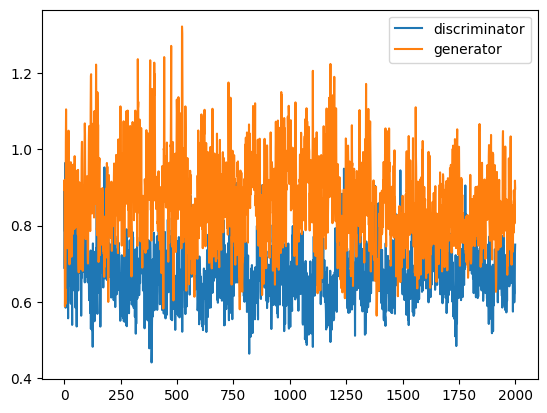

In [ ]:
plt.plot(dis_loss,label='discriminator')
plt.plot(gen_loss,label='generator')
plt.legend()
plt.show()

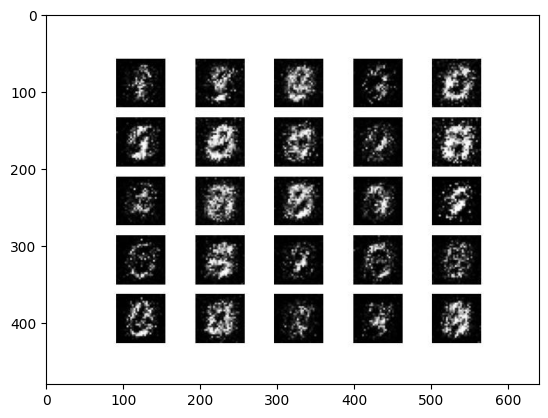

In [ ]:
img=plt.imread('gan_images/0.jpg')
plt.imshow(img)

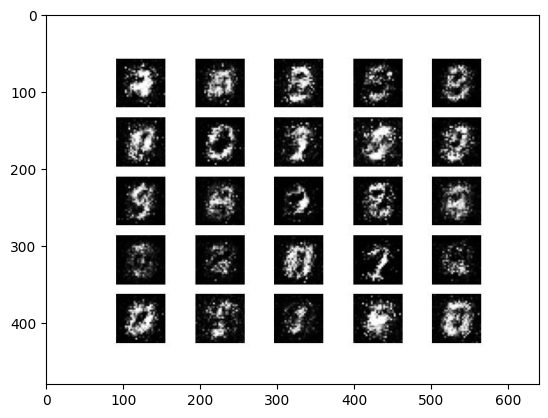

In [ ]:
img=plt.imread('gan_images/500.jpg')
plt.imshow(img)

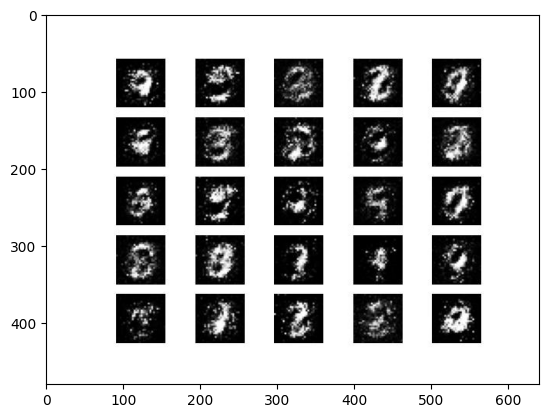

In [ ]:
img=plt.imread('gan_images/1000.jpg')
plt.imshow(img)

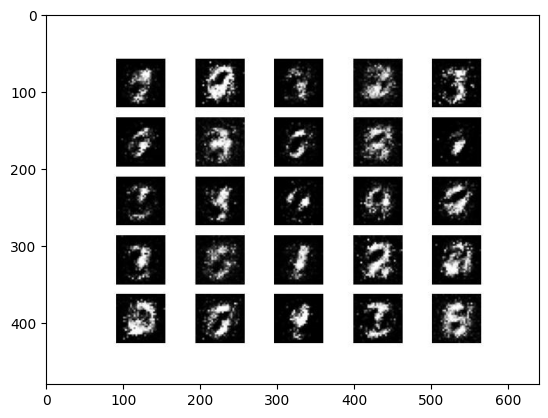

In [ ]:
img=plt.imread('gan_images/1500.jpg')
plt.imshow(img)